## Part 1) Choice of Data Source

Let ut use the `human_mitosis` dataset that comes with the [skimage library](https://github.com/scikit-image/scikit-image). It is a uint8 fluorescence microscopy image.

## Part 2) Choice of Frameworks

Investigate data processing and visualization frameworks and choose which ones to use in your project.
Create a brief comparison of the frameworks you have researched, their benefits and drawbacks and how they can interact / support each other. 
Make sure they can either support the data format you have choosen or outline how you are going to load the data otherwise.

In [ ]:
# general
import numpy as np
import math
import pandas as pd

# image loading
from skimage import data

# preprocessing
from skimage.filters import gaussian
from skimage.filters import threshold_otsu

# segmentation
from skimage.measure import label
from stardist.models import StarDist2D

# feature extraction
from skimage.measure import regionprops

# clustering 
import umap
from sklearn.cluster import KMeans

# visualization
import stackview
import matplotlib.pyplot as plt
import seaborn as sns

# neighborhood analysis
import pyclesperanto_prototype as cle

## Part 3) Loading the Data

StackViewNDArray([[ 8,  8,  8, ..., 63, 78, 75],
                  [ 8,  8,  7, ..., 67, 71, 71],
                  [ 9,  8,  8, ..., 53, 64, 66],
                  ...,
                  [ 8,  9,  8, ..., 17, 24, 59],
                  [ 8,  8,  8, ..., 17, 22, 55],
                  [ 8,  8,  8, ..., 16, 18, 38]], dtype=uint8)
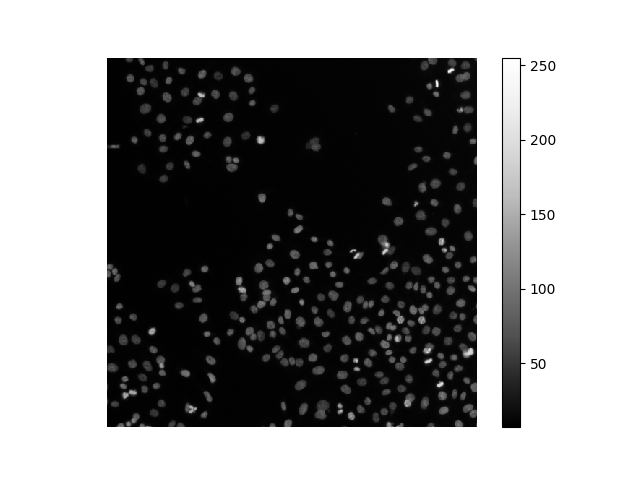
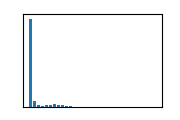

In [2]:
image = data.human_mitosis()

stackview.insight(image)

### Hypotheses:

__Hypothesis 1:__ The intensity of the chromatin in cells increases during mitosis.

__Hypothesis 2:__ The number of neighboring cells that are in the same phase of mitosis is higher in certain regions of the image, indicating a spatial correlation between cell cycle progression.

## Part 4) Cleaning the data

Your data set may have some quirks, strange formatting, incomplete entries or invalid data.
Note down any particularities you find and your intended steps to correct them.
Clean up the raw data you have loaded to bring it into a presentable shape, that can serve as the basis of future processing steps without having to worry about corner cases.
You may create, split, combine, discard, re-format or re-label rows and columns as needed.
Try to keep the cleaning procedure as generic as possible, so it could also work on a different data set of the same kind.

In [3]:
# Add your data cleaning code here
# After cleaning, print out the same sample as before, but this time in the cleaned state

StackViewNDArray([[0.03147407, 0.0312145 , 0.03101078, ..., 0.23563382,
                   0.27485459, 0.28743902],
                  [0.03201622, 0.03138104, 0.03090503, ..., 0.22507952,
                   0.26146368, 0.27447849],
                  [0.03279859, 0.03211894, 0.03160971, ..., 0.20237295,
                   0.24003942, 0.25731509],
                  ...,
                  [0.03189504, 0.03200721, 0.03150998, ..., 0.07650608,
                   0.1202781 , 0.17720847],
                  [0.03161322, 0.0317396 , 0.03148758, ..., 0.07409934,
                   0.11242074, 0.16363831],
                  [0.0314237 , 0.03144408, 0.03127161, ..., 0.07003586,
                   0.0999463 , 0.14088554]])
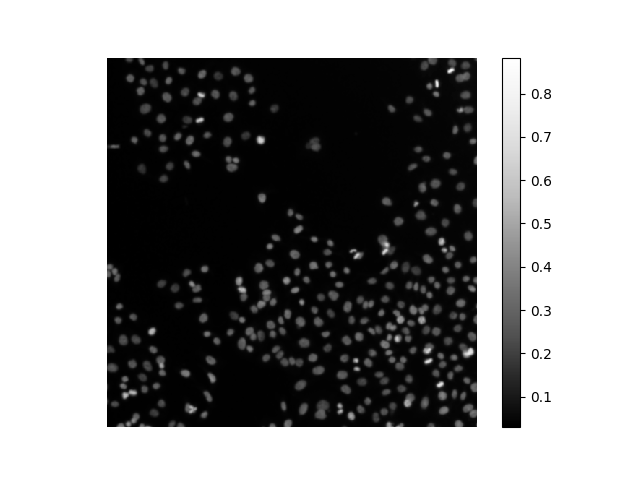
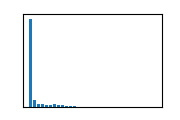

In [4]:
# Gaussian blur
image_gaussian = gaussian(image, sigma=1)
stackview.insight(image_gaussian)

_static_view.py (101): Converting input from bool to <class 'numpy.uint8'> for compatibility.


StackViewNDArray([[False, False, False, ...,  True,  True,  True],
                  [False, False, False, ...,  True,  True,  True],
                  [False, False, False, ...,  True,  True,  True],
                  ...,
                  [False, False, False, ..., False, False,  True],
                  [False, False, False, ..., False, False,  True],
                  [False, False, False, ..., False, False, False]])
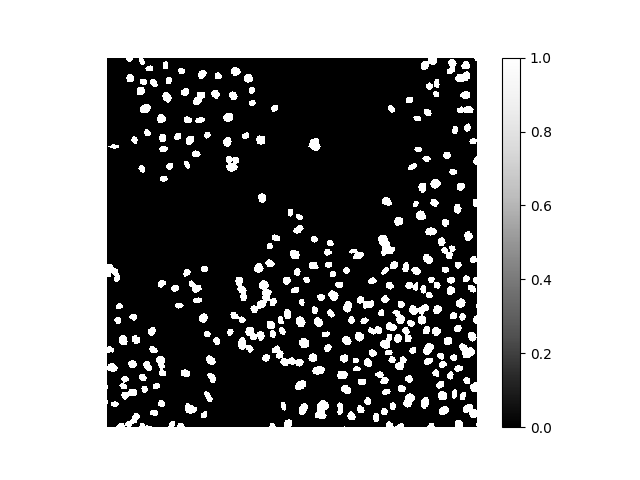
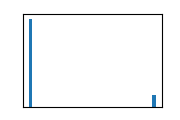

In [5]:
#threshold otsu
thresh = threshold_otsu(image_gaussian)
image_binary = image_gaussian > thresh
stackview.insight(image_binary)

StackViewNDArray([[  0,   0,   0, ...,   5,   5,   5],
                  [  0,   0,   0, ...,   5,   5,   5],
                  [  0,   0,   0, ...,   5,   5,   5],
                  ...,
                  [  0,   0,   0, ...,   0,   0, 275],
                  [  0,   0,   0, ...,   0,   0, 275],
                  [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)
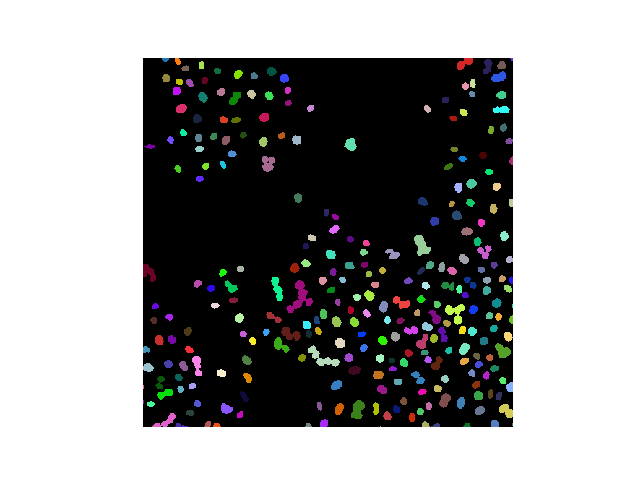

In [6]:
# Voronoi Otsu Labeling
img_labeled = label(image_binary)
stackview.insight(img_labeled)

Many dense nuclei are merged, so let us try out stardist here.

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 512, 512, 1))


StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
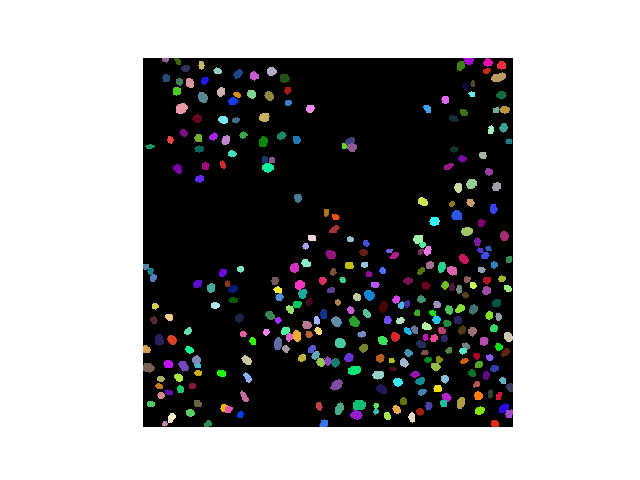

In [7]:
# Load a pre-trained 2D model (Versatile Fluorescent Nuclei)
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Run prediction
labels, _ = model.predict_instances(image_gaussian)

stackview.insight(labels)

This looks way better!

In [8]:
properties = regionprops(labels, intensity_image=image)

In [9]:
statistics = {
    'area':       [p.area               for p in properties],
    'mean':       [p.mean_intensity     for p in properties],
    'min':        [p.min_intensity      for p in properties],
    'max':        [p.max_intensity      for p in properties],
    'major_axis': [p.major_axis_length  for p in properties],
    'minor_axis': [p.minor_axis_length for p in properties],
    'centroid':   [p.centroid for p in properties],
    'coords':     [p.coords for p in properties],
    
    # added new properties
    'eccentricity': [p.eccentricity for p in properties],
    'solidity': [p.solidity for p in properties],
    'extent': [p.extent for p in properties],
    'perimeter': [p.perimeter for p in properties],
    'equivalent_diameter': [p.equivalent_diameter for p in properties],
}

df = pd.DataFrame(statistics)

# Add new columns interesting for determining mitotic phases
df['circularity'] = 4 * math.pi * df['area'] / (df['perimeter'] ** 2)
df['condensation_ratio'] = df['max'] / df['mean']

# View the updated DataFrame
df.head()

,area,mean,min,max,major_axis,minor_axis,centroid,coords,eccentricity,solidity,extent,perimeter,equivalent_diameter,circularity,condensation_ratio
0,101.0,122.108911,48.0,162.0,12.032226,10.737512,"(114.42574257425743, 211.990099009901)","[[109, 211], [109, 212], [110, 208], [110, 209...",0.451253,0.935185,0.765152,35.556349,11.340070,1.003915,1.326685
1,122.0,79.008197,41.0,116.0,13.078726,11.861871,"(468.1639344262295, 463.5245901639344)","[[462, 462], [462, 463], [462, 464], [463, 460...",0.421219,0.960630,0.782051,38.384776,12.463355,1.040523,1.468202
2,163.0,56.484663,17.0,82.0,15.988471,13.014338,"(366.1042944785276, 291.9447852760736)","[[359, 289], [359, 290], [359, 291], [359, 292...",0.580889,0.958824,0.724444,45.455844,14.406181,0.991329,1.451722
3,126.0,68.761905,27.0,94.0,13.241216,12.144300,"(386.76190476190476, 348.3174603174603)","[[381, 345], [381, 346], [381, 347], [381, 348...",0.398522,0.954545,0.807692,39.556349,12.666025,1.011924,1.367036
4,134.0,62.201493,23.0,85.0,13.938847,12.235981,"(415.6194029850746, 284.5)","[[410, 282], [410, 283], [410, 284], [410, 285...",0.478967,0.964029,0.797619,40.384776,13.061933,1.032474,1.366527


## Part 5) Fundamental Exploration

Create a statistical analysis for each of the properties recorded in the data set.

* For numerical data calculate the minimum and maximum values and where/when they appear, the mean value as well as the standard derivation.
* For categorical data create a table how often each category appears
* For time/date colums indicate the covered timespan and the average frequency of events
* For any other kind of data discuss and implement a suitable statistical characterization

In [10]:
# Implement your statistical analysis here
# Print the analysis results

In [24]:
# Step 1: Select the features for UMAP
# Let's exclude 'coords' because it's variable-length and not numeric-flat
feature_columns = ['area', 'mean', 'min', 'max', 
                   'major_axis', 'minor_axis', 
                   'eccentricity', 'solidity', 
                   'extent', 'perimeter', 'equivalent_diameter', 
                   'circularity','condensation_ratio']

X = df[feature_columns].to_numpy()

# Step 2: Fit UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)  # shape (n_samples, 2)

# Step 3: Add UMAP columns
df['UMAP_0'] = embedding[:, 0]
df['UMAP_1'] = embedding[:, 1]

deprecation.py (151): 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
umap_.py (1952): n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


In [25]:
stackview.clusterplot(image = image,
                      labels = labels,
                      df = df,
                      column_x = 'UMAP_0',
                      column_y = 'UMAP_1',
                      zoom_factor = 1.6,
                      alpha = 0.7)

In [ ]:
# Convert phases to integer labels (0, 1, 2, 3)
label_array = df['phase'].cat.codes.values


ValueError: cannot reshape array of size 314 into shape (100,100)

## Part 6) Visualization

Choose a _value over time_ or _two sequences of values_. 
Shortly discuss how they are related (or how the value behaves with relation to time) and which visualization forms are suitable to present this relationship.
Create a plot to visualize this relationship between these values.

In [50]:
# Implement your visualization here

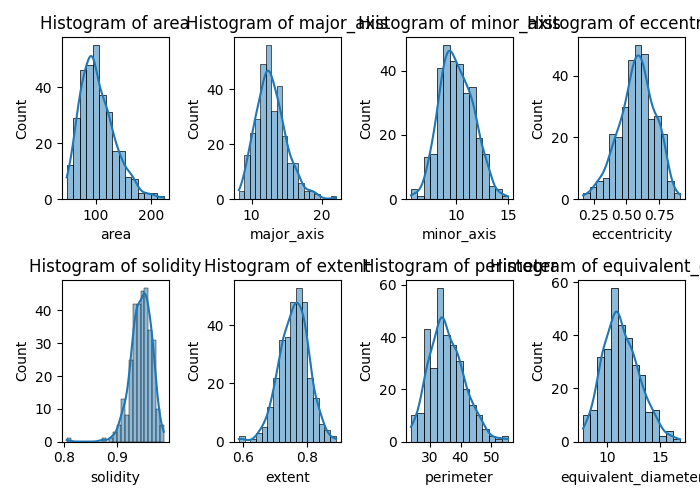

In [51]:
numerical_columns = ['area',
                   'major_axis', 'minor_axis', 
                   'eccentricity', 'solidity', 
                   'extent', 'perimeter', 'equivalent_diameter']

plt.figure(figsize=(7, 5))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

In [52]:
stackview.clusterplot(image = image,
                      labels = img_labeled,
                      df = df,
                      column_x = 'area',
                      column_y = 'solidity',
                      zoom_factor = 1.6,
                      alpha = 0.7)

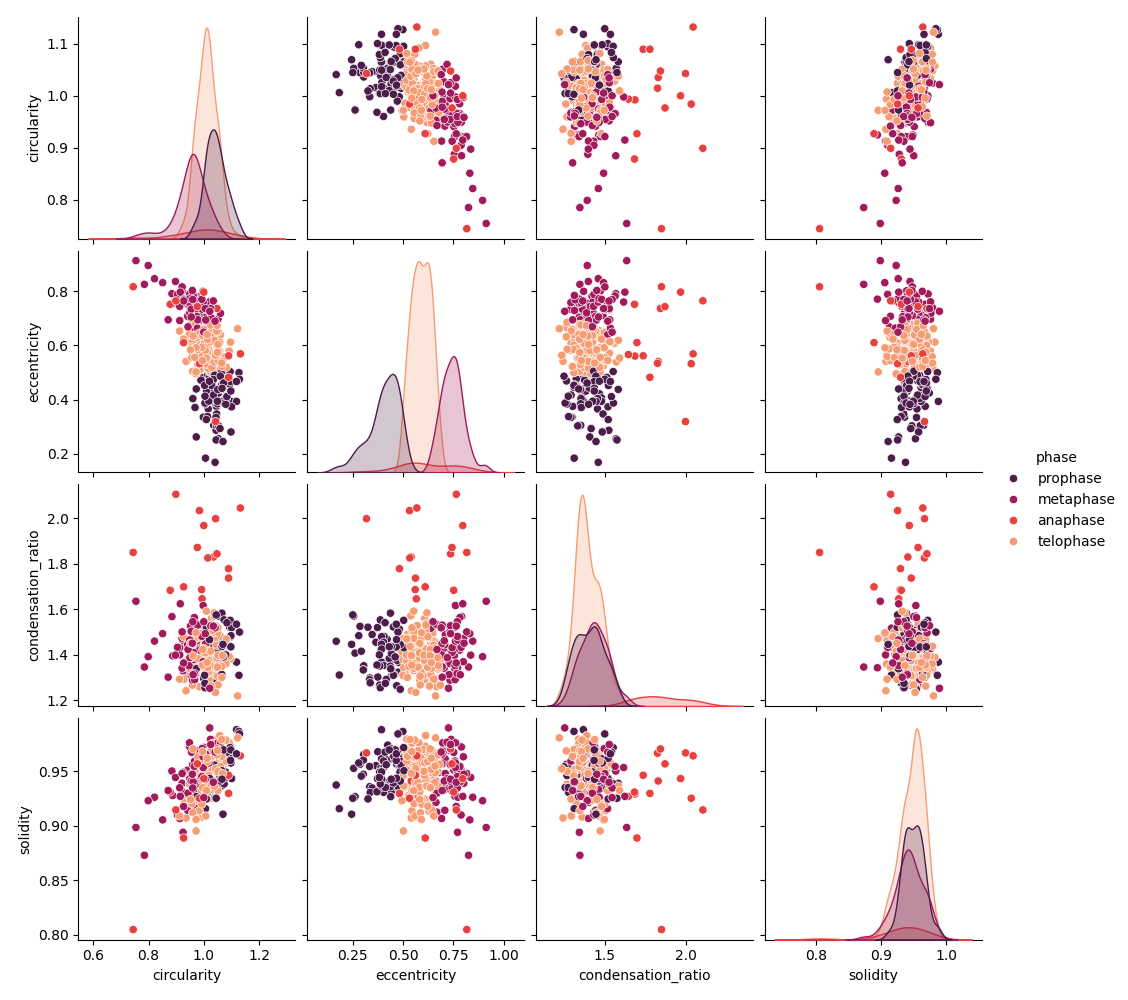

In [46]:
import pandas as pd
import seaborn as sns

# Select features for clustering
features = ['circularity', 'eccentricity', 'condensation_ratio', 'solidity']
X = df[features]

# Cluster into 4 groups
kmeans = KMeans(n_clusters=4, random_state=42)
df['predicted_phase'] = kmeans.fit_predict(X)

# Map cluster IDs to phase names
phase_map = {
    0: 'prophase',
    1: 'metaphase',
    2: 'anaphase',
    3: 'telophase'
}
df['phase'] = df['predicted_phase'].map(phase_map)

# Define the biological order explicitly
phase_order = ['prophase', 'metaphase', 'anaphase', 'telophase']
df['phase'] = pd.Categorical(df['phase'], categories=phase_order, ordered=True)

# Create a new DataFrame with labeled phases
plot_df = df[features + ['phase']]

# Use the same color palette and plot
sns.pairplot(plot_df, hue='phase', vars=features, palette='rocket', hue_order=phase_order)

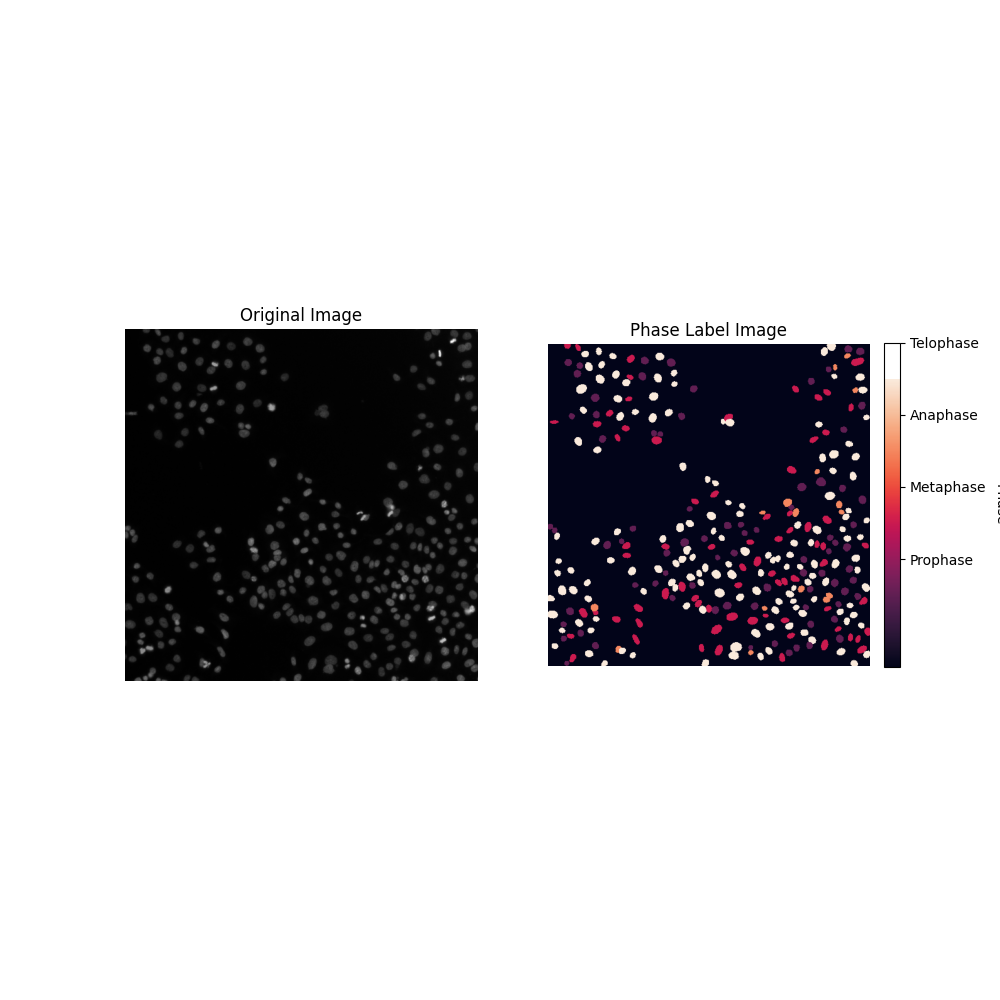

In [60]:
# Create a label image for visualization
phase_label_image = np.zeros_like(labels, dtype=np.int32)

# Map each region's phase label to the corresponding pixels in the label image
for region, phase_label in zip(properties, df['phase'].cat.codes):
    phase_label_image[tuple(region.coords.T)] = phase_label + 1  # Add 1 to avoid 0 for background

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# Show the original image on the left
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Show the phase label image on the right with the 'rocket' colormap
im = ax[1].imshow(phase_label_image, cmap='rocket')
ax[1].set_title('Phase Label Image')
ax[1].axis('off')

# Add a colorbar with phase labels
cbar = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_ticks([1.5, 2.5, 3.5, 4.5])
cbar.set_ticklabels(['Prophase', 'Metaphase', 'Anaphase', 'Telophase'])
cbar.set_label('Phase', rotation=270, labelpad=15)
plt.show()

## Part 7) Bonus: Highlight

Find a section in your data set with notable features (like strong derivations, extreme values, suspicious corelations, …).
Characterize those sections verbally and by statistical means and visualize the notable features.
Use a different kinds of visualization to explain the observed features.

In [5]:
# Add your highlight code here

/Users/maralampert/miniforge3/envs/allrounder_env/lib/python3.12/site-packages/pyclesperanto_prototype/_tier9/_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


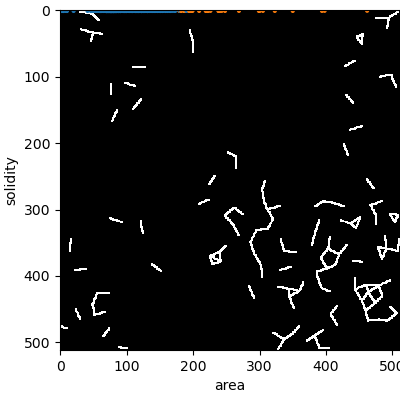

In [28]:
max_distance = 20

proximal_neighbor_mesh = cle.draw_mesh_between_proximal_labels(img_labeled, maximum_distance=max_distance)

# we make the lines a bit thicker for visualization purposes
proximal_neighbor_mesh = cle.maximum_box(proximal_neighbor_mesh, radius_x=1, radius_y=1)

cle.imshow(proximal_neighbor_mesh)